In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn 
import pandas as pd
import os
import sys
import struct
import time
from torch.autograd import Variable
import re
from torch.utils.data.dataset import Dataset
import torchvision
print(sys.version_info)
for module in mpl,np,sklearn,torch,re:
    print(module.__name__,module.__version__)

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.2
sklearn 0.22.2.post1
torch 1.4.0+cpu
re 2.2.1


In [2]:
train_data = torchvision.datasets.MNIST(root='./../data_set/mnist_pytorch/',train=True,transform=torchvision.transforms.ToTensor(),download=False)

RuntimeError: Dataset not found. You can use download=True to download it

In [3]:

# 训练集文件
#train_images_idx3_ubyte_file = '/MNIST/train-images-idx3-ubyte'
# 训练集标签文件
#train_labels_idx1_ubyte_file = 'MNIST/train-labels-idx1-ubyte'

# 训练集文件
train_images_idx3_ubyte_file = './../data_set/MNIST/train-images-idx3-ubyte'
# 训练集标签文件
train_labels_idx1_ubyte_file = './../data_set/MNIST/train-labels-idx1-ubyte'

In [4]:
def decode_idx3_ubyte(idx3_ubyte_file):
    """
    解析idx3文件的通用函数
    :param idx3_ubyte_file: idx3文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx3_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数、图片数量、每张图片高、每张图片宽
    offset = 0
    fmt_header = '>iiii' #因为数据结构中前4行的数据类型都是32位整型，所以采用i格式，但我们需要读取前4行数据，所以需要4个i。我们后面会看到标签集中，只使用2个ii。
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print('魔数:%d, 图片数量: %d张, 图片大小: %d*%d' % (magic_number, num_images, num_rows, num_cols))

    # 解析数据集
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)  #获得数据在缓存中的指针位置，从前面介绍的数据结构可以看出，读取了前4行之后，指针位置（即偏移位置offset）指向0016。
    print(offset)
    fmt_image = '>' + str(image_size) + 'B'  #图像数据像素值的类型为unsigned char型，对应的format格式为B。这里还有加上图像大小784，是为了读取784个B格式数据，如果没有则只会读取一个值（即一副图像中的一个像素值）
    print(fmt_image,offset,struct.calcsize(fmt_image))
    images = np.empty((num_images, num_rows, num_cols))
    #plt.figure()
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print('已解析 %d' % (i + 1) + '张')
            print(offset)
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        #print(images[i])
        offset += struct.calcsize(fmt_image)
#        plt.imshow(images[i],'gray')
#        plt.pause(0.00001)
#        plt.show()
    #plt.show()

    return images


def decode_idx1_ubyte(idx1_ubyte_file):
    """
    解析idx1文件的通用函数
    :param idx1_ubyte_file: idx1文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx1_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数和标签数
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print('魔数:%d, 图片数量: %d张' % (magic_number, num_images))

    # 解析数据集
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print ('已解析 %d' % (i + 1) + '张')
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels


In [5]:
def load_train_images(idx_ubyte_file=train_images_idx3_ubyte_file):
    """
    TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(idx_ubyte_file)
def load_train_labels(idx_ubyte_file=train_labels_idx1_ubyte_file):
    """
    TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)


魔数:2051, 图片数量: 60000张, 图片大小: 28*28
16
>784B 16 784
已解析 10000张
7839232
已解析 20000张
15679232
已解析 30000张
23519232
已解析 40000张
31359232
已解析 50000张
39199232
已解析 60000张
47039232
魔数:2049, 图片数量: 60000张
已解析 10000张
已解析 20000张
已解析 30000张
已解析 40000张
已解析 50000张
已解析 60000张
5.0


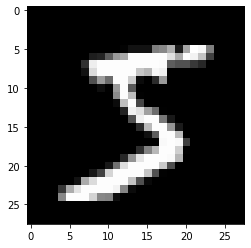

0.0


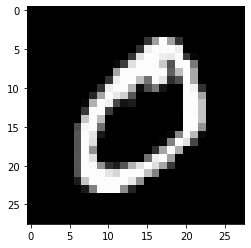

4.0


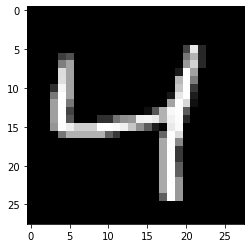

1.0


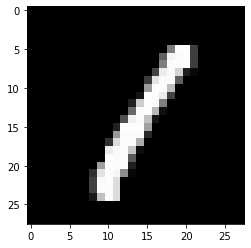

9.0


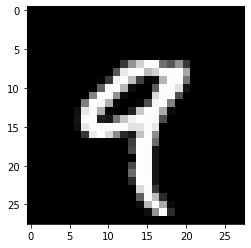

2.0


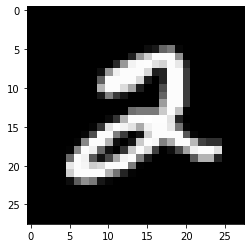

1.0


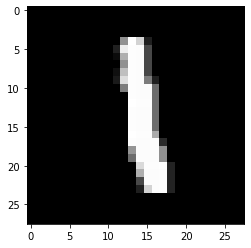

3.0


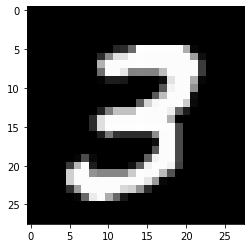

1.0


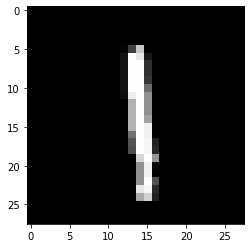

4.0


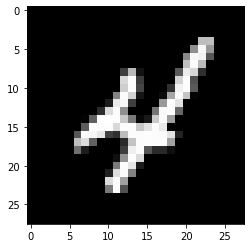

In [34]:

train_images = load_train_images()
train_labels = load_train_labels()
# test_images = load_test_images()
# test_labels = load_test_labels()

# 查看前十个数据及其标签以读取是否正确
for i in range(10):
    print(train_labels[i])
    plt.imshow(train_images[i], cmap='gray')
    plt.pause(0.000001)
    plt.show()

In [35]:
print(type(train_labels))
print(train_labels.shape)

print(train_images.shape)
print(type(train_images))

<class 'numpy.ndarray'>
(60000,)
(60000, 28, 28)
<class 'numpy.ndarray'>


In [36]:
49*32

1568

In [37]:
print(train_labels[10:])

[3. 5. 3. ... 5. 6. 8.]


In [38]:
dir(np.ndarray)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__

In [11]:
a=np.ndarray(np.arange(10))

In [12]:
b=np.arange(10)
b

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [13]:
n=np.array([1,2,3,4,4,5,56,67])
type(n)

numpy.ndarray

In [39]:
import collections
collections.Counter(train_labels[:-1000])

Counter({5.0: 5331,
         0.0: 5825,
         4.0: 5746,
         1.0: 6640,
         9.0: 5851,
         2.0: 5853,
         3.0: 6028,
         6.0: 5811,
         7.0: 6158,
         8.0: 5757})

In [42]:
collections.Counter(labelss)

Counter({4.0: 5331,
         9.0: 5825,
         3.0: 5746,
         0.0: 6640,
         8.0: 5851,
         1.0: 5853,
         2.0: 6028,
         5.0: 5811,
         6.0: 6158,
         7.0: 5757})

In [33]:
collections.Counter(labelss)

Counter({3.0: 2173,
         8.0: 2294,
         2.0: 8897,
         9.0: 10171,
         7.0: 9124,
         0.0: 2489,
         1.0: 6241,
         4.0: 5636,
         5.0: 9491,
         6.0: 2484})

In [25]:
sum(labels-train_labels[:-1000])

0.0

In [17]:
num=collections.Counter(train_labels[:-1000])

In [18]:
m=np.eye(3)
m[0,]=2

In [19]:
m=np.zeros([5])

In [20]:
m

array([0., 0., 0., 0., 0.])

In [40]:
def generate_avg_noise(labels,noise_rate,class_num,sum_per_class):
    """
    noise_rate分到每一类的概率
    """
    per_class_num=np.eye(class_num)
    rate_per_class=noise_rate/(class_num-1)
    for i in range(10):
        per_class_num[i,]=int(rate_per_class*sum_per_class[i])
        per_class_num[i,i]=sum_per_class[i]-(class_num-1)*per_class_num[i,i]
    for i in range(len(labels)):
        for j in range(10):
            if per_class_num[int(labels[i])][j]>=0:
                if labels[i]==0:
                    labels[i]=9.0
                else: 
                    labels[i]=labels[i]-1
                per_class_num[int(labels[i])][j]-=1
                break
    return labels
def generate_one_noise(labels,noise_rate,class_num,sum_per_class):
    """
    noise_rate 标签变为前一类的标签(第一类变为最后一类)
    """
    noise_sum=np.zeros([class_num])
    for i in range(class_num):
        noise_sum[i]=int(noise_rate*sum_per_class[i])
    print(noise_sum[int(5.0)])
    for i in range(len(labels)):
#         print(labels[i])
        if noise_sum[int(labels[i])]>=0:
            print('=============')
            print(labels[i])
            if labels[i] == 0:
                labels[i]=9.0
            else:
                labels[i]=labels[i]-1
            print(labels[i])
        noise_sum[int(labels[i])]-=1
    return labels
def generate_noise_label(labels,noise_rate,is_avg=True):
    """
    生成噪声标签，按照两种方法：( 1 - noise_rate )  是标签不变的
        1、is_avg = True noise_rate平均到其他每种类别
        2、is_avg = False noise_rate 标签变为前一类的标签(第一类变为最后一类)
    """
    class_num=10
    sum_per_class=collections.Counter(labels)
    if is_avg:
        return generate_avg_noise(labels,noise_rate,class_num,sum_per_class)
    else:
        return generate_one_noise(labels,noise_rate,class_num,sum_per_class)

In [41]:
labelss=generate_noise_label(train_labels[:-1000],0.45,True)

In [22]:
labels=generate_noise_label(train_labels[:-1000],0.45,False)

2398.0
5.0
4.0
0.0
9.0
4.0
3.0
1.0
0.0
9.0
8.0
2.0
1.0
1.0
0.0
3.0
2.0
1.0
0.0
4.0
3.0
3.0
2.0
5.0
4.0
3.0
2.0
6.0
5.0
1.0
0.0
7.0
6.0
2.0
1.0
8.0
7.0
6.0
5.0
9.0
8.0
4.0
3.0
0.0
9.0
9.0
8.0
1.0
0.0
1.0
0.0
2.0
1.0
4.0
3.0
3.0
2.0
2.0
1.0
7.0
6.0
3.0
2.0
8.0
7.0
6.0
5.0
9.0
8.0
0.0
9.0
5.0
4.0
6.0
5.0
0.0
9.0
7.0
6.0
6.0
5.0
1.0
0.0
8.0
7.0
7.0
6.0
9.0
8.0
3.0
2.0
9.0
8.0
8.0
7.0
5.0
4.0
9.0
8.0
3.0
2.0
3.0
2.0
0.0
9.0
7.0
6.0
4.0
3.0
9.0
8.0
8.0
7.0
0.0
9.0
9.0
8.0
4.0
3.0
1.0
0.0
4.0
3.0
4.0
3.0
6.0
5.0
0.0
9.0
4.0
3.0
5.0
4.0
6.0
5.0
1.0
0.0
0.0
9.0
0.0
9.0
1.0
0.0
7.0
6.0
1.0
0.0
6.0
5.0
3.0
2.0
0.0
9.0
2.0
1.0
1.0
0.0
1.0
0.0
7.0
6.0
9.0
8.0
0.0
9.0
2.0
1.0
6.0
5.0
7.0
6.0
8.0
7.0
3.0
2.0
9.0
8.0
0.0
9.0
4.0
3.0
6.0
5.0
7.0
6.0
4.0
3.0
6.0
5.0
8.0
7.0
0.0
9.0
7.0
6.0
8.0
7.0
3.0
2.0
1.0
0.0
5.0
4.0
7.0
6.0
1.0
0.0
7.0
6.0
1.0
0.0
1.0
0.0
6.0
5.0
3.0
2.0
0.0
9.0
2.0
1.0
9.0
8.0
3.0
2.0
1.0
0.0
1.0
0.0
0.0
9.0
4.0
3.0
9.0
8.0
2.0
1.0
0.0
9.0
0.0
9.0
2.0
1.0
0.0
9.0
2.0
1.0
7.0
6.0
1

5.0
4.0
3.0
2.0
7.0
6.0
0.0
9.0
9.0
8.0
5.0
4.0
8.0
7.0
3.0
2.0
2.0
1.0
0.0
9.0
1.0
0.0
8.0
7.0
3.0
2.0
0.0
9.0
1.0
0.0
2.0
1.0
3.0
2.0
4.0
3.0
0.0
9.0
0.0
9.0
1.0
0.0
7.0
6.0
2.0
1.0
9.0
8.0
3.0
2.0
9.0
8.0
4.0
3.0
2.0
1.0
5.0
4.0
8.0
7.0
6.0
5.0
7.0
6.0
7.0
6.0
9.0
8.0
8.0
7.0
9.0
8.0
9.0
8.0
2.0
1.0
0.0
9.0
0.0
9.0
1.0
0.0
4.0
3.0
2.0
1.0
4.0
3.0
3.0
2.0
9.0
8.0
4.0
3.0
3.0
2.0
5.0
4.0
7.0
6.0
6.0
5.0
5.0
4.0
7.0
6.0
1.0
0.0
8.0
7.0
6.0
5.0
9.0
8.0
3.0
2.0
0.0
9.0
4.0
3.0
1.0
0.0
2.0
1.0
2.0
1.0
5.0
4.0
3.0
2.0
7.0
6.0
4.0
3.0
1.0
0.0
7.0
6.0
7.0
6.0
8.0
7.0
1.0
0.0
9.0
8.0
2.0
1.0
3.0
2.0
2.0
1.0
4.0
3.0
0.0
9.0
1.0
0.0
8.0
7.0
4.0
3.0
3.0
2.0
6.0
5.0
5.0
4.0
6.0
5.0
4.0
3.0
7.0
6.0
9.0
8.0
3.0
2.0
1.0
0.0
3.0
2.0
0.0
9.0
2.0
1.0
1.0
0.0
1.0
0.0
0.0
9.0
9.0
8.0
9.0
8.0
4.0
3.0
6.0
5.0
7.0
6.0
6.0
5.0
3.0
2.0
5.0
4.0
5.0
4.0
4.0
3.0
4.0
3.0
6.0
5.0
9.0
8.0
1.0
0.0
1.0
0.0
3.0
2.0
1.0
0.0
1.0
0.0
0.0
9.0
5.0
4.0
1.0
0.0
4.0
3.0
4.0
3.0
6.0
5.0
6.0
5.0
6.0
5.0
0.0
9.0
1.0
0.0
2.0
1.0


0.0
9.0
7.0
6.0
7.0
6.0
8.0
7.0
7.0
6.0
7.0
6.0
8.0
7.0
7.0
6.0
9.0
8.0
9.0
8.0
3.0
2.0
0.0
9.0
4.0
3.0
4.0
3.0
0.0
9.0
9.0
8.0
3.0
2.0
9.0
8.0
5.0
4.0
7.0
6.0
6.0
5.0
0.0
9.0
7.0
6.0
5.0
4.0
1.0
0.0
8.0
7.0
2.0
1.0
5.0
4.0
7.0
6.0
9.0
8.0
4.0
3.0
8.0
7.0
4.0
3.0
8.0
7.0
7.0
6.0
7.0
6.0
9.0
8.0
5.0
4.0
0.0
9.0
6.0
5.0
6.0
5.0
5.0
4.0
4.0
3.0
3.0
2.0
9.0
8.0
8.0
7.0
6.0
5.0
1.0
0.0
9.0
8.0
6.0
5.0
7.0
6.0
8.0
7.0
2.0
1.0
5.0
4.0
9.0
8.0
9.0
8.0
2.0
1.0
2.0
1.0
1.0
0.0
2.0
1.0
2.0
1.0
0.0
9.0
9.0
8.0
9.0
8.0
4.0
3.0
2.0
1.0
3.0
2.0
4.0
3.0
9.0
8.0
7.0
6.0
3.0
2.0
3.0
2.0
3.0
2.0
1.0
0.0
9.0
8.0
3.0
2.0
7.0
6.0
6.0
5.0
5.0
4.0
6.0
5.0
0.0
9.0
2.0
1.0
6.0
5.0
1.0
0.0
3.0
2.0
2.0
1.0
4.0
3.0
6.0
5.0
3.0
2.0
0.0
9.0
8.0
7.0
2.0
1.0
4.0
3.0
2.0
1.0
2.0
1.0
7.0
6.0
1.0
0.0
1.0
0.0
9.0
8.0
3.0
2.0
9.0
8.0
7.0
6.0
4.0
3.0
4.0
3.0
4.0
3.0
8.0
7.0
8.0
7.0
9.0
8.0
5.0
4.0
2.0
1.0
3.0
2.0
9.0
8.0
4.0
3.0
5.0
4.0
2.0
1.0
6.0
5.0
6.0
5.0
8.0
7.0
6.0
5.0
0.0
9.0
7.0
6.0
0.0
9.0
4.0
3.0
9.0
8.0
7.0
6.0


1.0
6.0
5.0
4.0
3.0
1.0
0.0
6.0
5.0
9.0
8.0
9.0
8.0
9.0
8.0
3.0
2.0
9.0
8.0
2.0
1.0
4.0
3.0
9.0
8.0
4.0
3.0
8.0
7.0
3.0
2.0
4.0
3.0
8.0
7.0
5.0
4.0
1.0
0.0
0.0
9.0
4.0
3.0
0.0
9.0
1.0
0.0
6.0
5.0
2.0
1.0
6.0
5.0
5.0
4.0
4.0
3.0
0.0
9.0
7.0
6.0
9.0
8.0
9.0
8.0
5.0
4.0
1.0
0.0
3.0
2.0
9.0
8.0
0.0
9.0
9.0
8.0
4.0
3.0
5.0
4.0
9.0
8.0
1.0
0.0
1.0
0.0
7.0
6.0
7.0
6.0
4.0
3.0
4.0
3.0
5.0
4.0
4.0
3.0
3.0
2.0
1.0
0.0
3.0
2.0
8.0
7.0
1.0
0.0
7.0
6.0
0.0
9.0
6.0
5.0
2.0
1.0
0.0
9.0
4.0
3.0
8.0
7.0
8.0
7.0
1.0
0.0
6.0
5.0
8.0
7.0
1.0
0.0
2.0
1.0
3.0
2.0
6.0
5.0
3.0
2.0
2.0
1.0
9.0
8.0
0.0
9.0
1.0
0.0
9.0
8.0
1.0
0.0
1.0
0.0
7.0
6.0
2.0
1.0
1.0
0.0
5.0
4.0
5.0
4.0
4.0
3.0
6.0
5.0
5.0
4.0
4.0
3.0
7.0
6.0
4.0
3.0
7.0
6.0
8.0
7.0
5.0
4.0
4.0
3.0
3.0
2.0
4.0
3.0
0.0
9.0
2.0
1.0
2.0
1.0
5.0
4.0
2.0
1.0
1.0
0.0
2.0
1.0
6.0
5.0
7.0
6.0
1.0
0.0
3.0
2.0
5.0
4.0
1.0
0.0
5.0
4.0
4.0
3.0
3.0
2.0
4.0
3.0
6.0
5.0
3.0
2.0
7.0
6.0
0.0
9.0
1.0
0.0
0.0
9.0
2.0
1.0
4.0
3.0
9.0
8.0
7.0
6.0
2.0
1.0
9.0
8.0
6.0
5.0
7.0


3.0
2.0
7.0
6.0
4.0
3.0
1.0
0.0
5.0
4.0
2.0
1.0
6.0
5.0
1.0
0.0
7.0
6.0
2.0
1.0
8.0
7.0
4.0
3.0
9.0
8.0
6.0
5.0
0.0
9.0
7.0
6.0
7.0
6.0
3.0
2.0
5.0
4.0
6.0
5.0
0.0
9.0
6.0
5.0
8.0
7.0
5.0
4.0
4.0
3.0
7.0
6.0
1.0
0.0
6.0
5.0
8.0
7.0
6.0
5.0
8.0
7.0
7.0
6.0
1.0
0.0
7.0
6.0
3.0
2.0
3.0
2.0
1.0
0.0
2.0
1.0
8.0
7.0
4.0
3.0
3.0
2.0
9.0
8.0
7.0
6.0
4.0
3.0
9.0
8.0
3.0
2.0
3.0
2.0
8.0
7.0
0.0
9.0
6.0
5.0
9.0
8.0
6.0
5.0
4.0
3.0
9.0
8.0
4.0
3.0
0.0
9.0
0.0
9.0
6.0
5.0
7.0
6.0
3.0
2.0
4.0
3.0
1.0
0.0
2.0
1.0
2.0
1.0
9.0
8.0
7.0
6.0
8.0
7.0
3.0
2.0
7.0
6.0
4.0
3.0
2.0
1.0
1.0
0.0
7.0
6.0
6.0
5.0
8.0
7.0
5.0
4.0
9.0
8.0
0.0
9.0
3.0
2.0
6.0
5.0
1.0
0.0
1.0
0.0
4.0
3.0
9.0
8.0
6.0
5.0
3.0
2.0
5.0
4.0
1.0
0.0
2.0
1.0
1.0
0.0
2.0
1.0
0.0
9.0
2.0
1.0
6.0
5.0
5.0
4.0
6.0
5.0
6.0
5.0
1.0
0.0
7.0
6.0
3.0
2.0
8.0
7.0
4.0
3.0
7.0
6.0
5.0
4.0
5.0
4.0
3.0
2.0
1.0
0.0
9.0
8.0
6.0
5.0
1.0
0.0
4.0
3.0
1.0
0.0
9.0
8.0
5.0
4.0
2.0
1.0
9.0
8.0
9.0
8.0
3.0
2.0
3.0
2.0
5.0
4.0
5.0
4.0
9.0
8.0
3.0
2.0
1.0
0.0
6.0
5.0


4.0
7.0
6.0
1.0
0.0
3.0
2.0
7.0
6.0
1.0
0.0
8.0
7.0
4.0
3.0
0.0
9.0
2.0
1.0
1.0
0.0
9.0
8.0
2.0
1.0
2.0
1.0
3.0
2.0
6.0
5.0
1.0
0.0
8.0
7.0
7.0
6.0
7.0
6.0
8.0
7.0
1.0
0.0
8.0
7.0
4.0
3.0
5.0
4.0
5.0
4.0
7.0
6.0
7.0
6.0
9.0
8.0
5.0
4.0
5.0
4.0
8.0
7.0
0.0
9.0
6.0
5.0
8.0
7.0
1.0
0.0
3.0
2.0
6.0
5.0
5.0
4.0
0.0
9.0
4.0
3.0
6.0
5.0
8.0
7.0
0.0
9.0
3.0
2.0
4.0
3.0
0.0
9.0
0.0
9.0
2.0
1.0
9.0
8.0
1.0
0.0
7.0
6.0
0.0
9.0
1.0
0.0
2.0
1.0
9.0
8.0
5.0
4.0
2.0
1.0
8.0
7.0
9.0
8.0
8.0
7.0
5.0
4.0
5.0
4.0
5.0
4.0
3.0
2.0
2.0
1.0
0.0
9.0
2.0
1.0
4.0
3.0
8.0
7.0
4.0
3.0
6.0
5.0
1.0
0.0
9.0
8.0
6.0
5.0
7.0
6.0
1.0
0.0
1.0
0.0
3.0
2.0
5.0
4.0
0.0
9.0
2.0
1.0
3.0
2.0
4.0
3.0
6.0
5.0
6.0
5.0
9.0
8.0
0.0
9.0
3.0
2.0
8.0
7.0
7.0
6.0
2.0
1.0
9.0
8.0
8.0
7.0
7.0
6.0
8.0
7.0
0.0
9.0
6.0
5.0
4.0
3.0
9.0
8.0
8.0
7.0
2.0
1.0
3.0
2.0
6.0
5.0
2.0
1.0
1.0
0.0
7.0
6.0
4.0
3.0
7.0
6.0
2.0
1.0
9.0
8.0
7.0
6.0
5.0
4.0
1.0
0.0
1.0
0.0
7.0
6.0
5.0
4.0
1.0
0.0
2.0
1.0
9.0
8.0
8.0
7.0
8.0
7.0
9.0
8.0
1.0
0.0
6.0
5.0
6.0


7.0
6.0
2.0
1.0
8.0
7.0
3.0
2.0
6.0
5.0
4.0
3.0
2.0
1.0
5.0
4.0
6.0
5.0
6.0
5.0
5.0
4.0
7.0
6.0
2.0
1.0
8.0
7.0
4.0
3.0
0.0
9.0
7.0
6.0
1.0
0.0
2.0
1.0
2.0
1.0
1.0
0.0
3.0
2.0
4.0
3.0
4.0
3.0
1.0
0.0
5.0
4.0
8.0
7.0
6.0
5.0
9.0
8.0
7.0
6.0
4.0
3.0
8.0
7.0
9.0
8.0
9.0
8.0
6.0
5.0
1.0
0.0
9.0
8.0
6.0
5.0
5.0
4.0
8.0
7.0
6.0
5.0
9.0
8.0
9.0
8.0
9.0
8.0
1.0
0.0
0.0
9.0
9.0
8.0
1.0
0.0
8.0
7.0
2.0
1.0
1.0
0.0
4.0
3.0
5.0
4.0
4.0
3.0
3.0
2.0
3.0
2.0
0.0
9.0
7.0
6.0
6.0
5.0
4.0
3.0
3.0
2.0
4.0
3.0
4.0
3.0
4.0
3.0
9.0
8.0
0.0
9.0
8.0
7.0
3.0
2.0
8.0
7.0
8.0
7.0
6.0
5.0
7.0
6.0
0.0
9.0
5.0
4.0
5.0
4.0
1.0
0.0
7.0
6.0
5.0
4.0
8.0
7.0
8.0
7.0
0.0
9.0
9.0
8.0
3.0
2.0
2.0
1.0
5.0
4.0
5.0
4.0
4.0
3.0
1.0
0.0
6.0
5.0
1.0
0.0
9.0
8.0
6.0
5.0
8.0
7.0
2.0
1.0
3.0
2.0
1.0
0.0
3.0
2.0
3.0
2.0
3.0
2.0
8.0
7.0
2.0
1.0
6.0
5.0
7.0
6.0
4.0
3.0
4.0
3.0
9.0
8.0
3.0
2.0
2.0
1.0
0.0
9.0
0.0
9.0
0.0
9.0
0.0
9.0
7.0
6.0
1.0
0.0
7.0
6.0
6.0
5.0
6.0
5.0
2.0
1.0
0.0
9.0
5.0
4.0
6.0
5.0
5.0
4.0
8.0
7.0
0.0
9.0
6.0
5.0


8.0
8.0
7.0
6.0
5.0
0.0
9.0
3.0
2.0
3.0
2.0
4.0
3.0
7.0
6.0
3.0
2.0
9.0
8.0
3.0
2.0
7.0
6.0
5.0
4.0
3.0
2.0
2.0
1.0
6.0
5.0
4.0
3.0
7.0
6.0
5.0
4.0
8.0
7.0
9.0
8.0
0.0
9.0
6.0
5.0
3.0
2.0
2.0
1.0
5.0
4.0
4.0
3.0
3.0
2.0
9.0
8.0
0.0
9.0
5.0
4.0
1.0
0.0
9.0
8.0
2.0
1.0
6.0
5.0
3.0
2.0
7.0
6.0
4.0
3.0
6.0
5.0
5.0
4.0
6.0
5.0
6.0
5.0
9.0
8.0
7.0
6.0
3.0
2.0
8.0
7.0
5.0
4.0
9.0
8.0
8.0
7.0
0.0
9.0
2.0
1.0
1.0
0.0
5.0
4.0
2.0
1.0
0.0
9.0
3.0
2.0
9.0
8.0
4.0
3.0
9.0
8.0
5.0
4.0
4.0
3.0
6.0
5.0
5.0
4.0
7.0
6.0
6.0
5.0
8.0
7.0
8.0
7.0
9.0
8.0
9.0
8.0
0.0
9.0
5.0
4.0
1.0
0.0
2.0
1.0
2.0
1.0
3.0
2.0
3.0
2.0
7.0
6.0
4.0
3.0
3.0
2.0
5.0
4.0
4.0
3.0
6.0
5.0
1.0
0.0
7.0
6.0
6.0
5.0
8.0
7.0
1.0
0.0
9.0
8.0
0.0
9.0
7.0
6.0
1.0
0.0
6.0
5.0
0.0
9.0
4.0
3.0
2.0
1.0
3.0
2.0
9.0
8.0
0.0
9.0
4.0
3.0
6.0
5.0
1.0
0.0
6.0
5.0
4.0
3.0
6.0
5.0
8.0
7.0
9.0
8.0
4.0
3.0
0.0
9.0
9.0
8.0
0.0
9.0
8.0
7.0
1.0
0.0
7.0
6.0
3.0
2.0
8.0
7.0
9.0
8.0
1.0
0.0
4.0
3.0
4.0
3.0
5.0
4.0
3.0
2.0
7.0
6.0
0.0
9.0
9.0
8.0
3.0
2.0
5.0


0.0
9.0
6.0
5.0
4.0
3.0
1.0
0.0
9.0
8.0
7.0
6.0
0.0
9.0
3.0
2.0
5.0
4.0
8.0
7.0
9.0
8.0
9.0
8.0
9.0
8.0
6.0
5.0
5.0
4.0
3.0
2.0
4.0
3.0
9.0
8.0
6.0
5.0
0.0
9.0
9.0
8.0
5.0
4.0
5.0
4.0
7.0
6.0
9.0
8.0
1.0
0.0
8.0
7.0
6.0
5.0
8.0
7.0
1.0
0.0
7.0
6.0
0.0
9.0
7.0
6.0
9.0
8.0
0.0
9.0
3.0
2.0
8.0
7.0
3.0
2.0
6.0
5.0
4.0
3.0
1.0
0.0
4.0
3.0
4.0
3.0
0.0
9.0
3.0
2.0
6.0
5.0
3.0
2.0
2.0
1.0
4.0
3.0
5.0
4.0
6.0
5.0
4.0
3.0
5.0
4.0
4.0
3.0
1.0
0.0
0.0
9.0
9.0
8.0
2.0
1.0
6.0
5.0
0.0
9.0
0.0
9.0
1.0
0.0
6.0
5.0
2.0
1.0
3.0
2.0
3.0
2.0
5.0
4.0
4.0
3.0
1.0
0.0
5.0
4.0
8.0
7.0
6.0
5.0
4.0
3.0
7.0
6.0
4.0
3.0
8.0
7.0
9.0
8.0
9.0
8.0
9.0
8.0
0.0
9.0
7.0
6.0
1.0
0.0
6.0
5.0
2.0
1.0
8.0
7.0
3.0
2.0
7.0
6.0
4.0
3.0
6.0
5.0
5.0
4.0
0.0
9.0
6.0
5.0
9.0
8.0
7.0
6.0
0.0
9.0
8.0
7.0
8.0
7.0
0.0
9.0
3.0
2.0
1.0
0.0
8.0
7.0
2.0
1.0
5.0
4.0
3.0
2.0
7.0
6.0
4.0
3.0
0.0
9.0
5.0
4.0
3.0
2.0
6.0
5.0
3.0
2.0
7.0
6.0
8.0
7.0
8.0
7.0
4.0
3.0
9.0
8.0
1.0
0.0
7.0
6.0
8.0
7.0
4.0
3.0
4.0
3.0
3.0
2.0
4.0
3.0
8.0
7.0
1.0
0.0


1.0
2.0
1.0
6.0
5.0
8.0
7.0
0.0
9.0
1.0
0.0
5.0
4.0
8.0
7.0
6.0
5.0
5.0
4.0
6.0
5.0
9.0
8.0
8.0
7.0
6.0
5.0
7.0
6.0
7.0
6.0
3.0
2.0
5.0
4.0
5.0
4.0
1.0
0.0
8.0
7.0
2.0
1.0
3.0
2.0
8.0
7.0
0.0
9.0
1.0
0.0
1.0
0.0
2.0
1.0
2.0
1.0
6.0
5.0
3.0
2.0
9.0
8.0
1.0
0.0
8.0
7.0
5.0
4.0
8.0
7.0
6.0
5.0
6.0
5.0
0.0
9.0
2.0
1.0
1.0
0.0
8.0
7.0
2.0
1.0
3.0
2.0
3.0
2.0
1.0
0.0
1.0
0.0
8.0
7.0
5.0
4.0
4.0
3.0
6.0
5.0
1.0
0.0
7.0
6.0
7.0
6.0
8.0
7.0
4.0
3.0
0.0
9.0
5.0
4.0
1.0
0.0
7.0
6.0
2.0
1.0
9.0
8.0
3.0
2.0
1.0
0.0
1.0
0.0
4.0
3.0
7.0
6.0
9.0
8.0
4.0
3.0
2.0
1.0
8.0
7.0
3.0
2.0
1.0
0.0
3.0
2.0
5.0
4.0
3.0
2.0
6.0
5.0
7.0
6.0
5.0
4.0
4.0
3.0
7.0
6.0
9.0
8.0
2.0
1.0
9.0
8.0
8.0
7.0
3.0
2.0
6.0
5.0
9.0
8.0
3.0
2.0
1.0
0.0
3.0
2.0
3.0
2.0
8.0
7.0
9.0
8.0
6.0
5.0
8.0
7.0
5.0
4.0
8.0
7.0
4.0
3.0
7.0
6.0
0.0
9.0
6.0
5.0
9.0
8.0
4.0
3.0
1.0
0.0
2.0
1.0
7.0
6.0
9.0
8.0
2.0
1.0
2.0
1.0
9.0
8.0
6.0
5.0
1.0
0.0
9.0
8.0
5.0
4.0
1.0
0.0
1.0
0.0
6.0
5.0
3.0
2.0
3.0
2.0
2.0
1.0
3.0
2.0
3.0
2.0
5.0
4.0
6.0
5.0
7.0


1.0
6.0
5.0
4.0
3.0
5.0
4.0
7.0
6.0
1.0
0.0
8.0
7.0
7.0
6.0
4.0
3.0
1.0
0.0
1.0
0.0
4.0
3.0
8.0
7.0
6.0
5.0
4.0
3.0
9.0
8.0
2.0
1.0
1.0
0.0
8.0
7.0
3.0
2.0
1.0
0.0
1.0
0.0
2.0
1.0
6.0
5.0
0.0
9.0
3.0
2.0
5.0
4.0
0.0
9.0
9.0
8.0
6.0
5.0
6.0
5.0
7.0
6.0
6.0
5.0
1.0
0.0
7.0
6.0
3.0
2.0
0.0
9.0
8.0
7.0
4.0
3.0
2.0
1.0
8.0
7.0
6.0
5.0
7.0
6.0
2.0
1.0
5.0
4.0
6.0
5.0
5.0
4.0
7.0
6.0
2.0
1.0
8.0
7.0
7.0
6.0
7.0
6.0
2.0
1.0
0.0
9.0
3.0
2.0
1.0
0.0
3.0
2.0
2.0
1.0
2.0
1.0
3.0
2.0
6.0
5.0
4.0
3.0
0.0
9.0
5.0
4.0
3.0
2.0
6.0
5.0
6.0
5.0
7.0
6.0
3.0
2.0
8.0
7.0
5.0
4.0
9.0
8.0
7.0
6.0
0.0
9.0
0.0
9.0
1.0
0.0
7.0
6.0
2.0
1.0
3.0
2.0
3.0
2.0
9.0
8.0
7.0
6.0
6.0
5.0
8.0
7.0
8.0
7.0
9.0
8.0
0.0
9.0
0.0
9.0
2.0
1.0
1.0
0.0
0.0
9.0
2.0
1.0
2.0
1.0
3.0
2.0
9.0
8.0
7.0
6.0
4.0
3.0
8.0
7.0
0.0
9.0
9.0
8.0
7.0
6.0
3.0
2.0
0.0
9.0
4.0
3.0
8.0
7.0
1.0
0.0
0.0
9.0
4.0
3.0
6.0
5.0
6.0
5.0
5.0
4.0
6.0
5.0
0.0
9.0
7.0
6.0
8.0
7.0
3.0
2.0
3.0
2.0
3.0
2.0
1.0
0.0
2.0
1.0
5.0
4.0
1.0
0.0
3.0
2.0
9.0
8.0
0.0
9.0
4.0


1.0
5.0
4.0
4.0
3.0
5.0
4.0
2.0
1.0
6.0
5.0
8.0
7.0
0.0
9.0
5.0
4.0
1.0
0.0
9.0
8.0
3.0
2.0
7.0
6.0
6.0
5.0
2.0
1.0
4.0
3.0
1.0
0.0
8.0
7.0
9.0
8.0
9.0
8.0
0.0
9.0
8.0
7.0
4.0
3.0
5.0
4.0
1.0
0.0
2.0
1.0
3.0
2.0
1.0
0.0
8.0
7.0
0.0
9.0
2.0
1.0
5.0
4.0
7.0
6.0
6.0
5.0
4.0
3.0
6.0
5.0
6.0
5.0
3.0
2.0
1.0
0.0
3.0
2.0
4.0
3.0
3.0
2.0
3.0
2.0
1.0
0.0
1.0
0.0
7.0
6.0
1.0
0.0
2.0
1.0
5.0
4.0
2.0
1.0
2.0
1.0
7.0
6.0
4.0
3.0
2.0
1.0
8.0
7.0
3.0
2.0
2.0
1.0
6.0
5.0
3.0
2.0
8.0
7.0
4.0
3.0
5.0
4.0
7.0
6.0
1.0
0.0
3.0
2.0
4.0
3.0
7.0
6.0
9.0
8.0
6.0
5.0
0.0
9.0
1.0
0.0
6.0
5.0
3.0
2.0
8.0
7.0
8.0
7.0
8.0
7.0
3.0
2.0
0.0
9.0
5.0
4.0
3.0
2.0
9.0
8.0
9.0
8.0
5.0
4.0
4.0
3.0
4.0
3.0
3.0
2.0
8.0
7.0
7.0
6.0
0.0
9.0
1.0
0.0
7.0
6.0
7.0
6.0
3.0
2.0
6.0
5.0
9.0
8.0
9.0
8.0
5.0
4.0
4.0
3.0
0.0
9.0
2.0
1.0
7.0
6.0
9.0
8.0
3.0
2.0
9.0
8.0
3.0
2.0
4.0
3.0
0.0
9.0
9.0
8.0
3.0
2.0
4.0
3.0
6.0
5.0
0.0
9.0
3.0
2.0
7.0
6.0
3.0
2.0
1.0
0.0
6.0
5.0
3.0
2.0
0.0
9.0
0.0
9.0
2.0
1.0
1.0
0.0
5.0
4.0
2.0
1.0
7.0
6.0
3.0


1.0
0.0
3.0
2.0
3.0
2.0
0.0
9.0
2.0
1.0
0.0
9.0
3.0
2.0
5.0
4.0
0.0
9.0
2.0
1.0
9.0
8.0
5.0
4.0
2.0
1.0
8.0
7.0
5.0
4.0
8.0
7.0
5.0
4.0
9.0
8.0
0.0
9.0
4.0
3.0
5.0
4.0
3.0
2.0
1.0
0.0
4.0
3.0
1.0
0.0
2.0
1.0
9.0
8.0
8.0
7.0
2.0
1.0
5.0
4.0
3.0
2.0
5.0
4.0
7.0
6.0
7.0
6.0
8.0
7.0
1.0
0.0
4.0
3.0
3.0
2.0
6.0
5.0
6.0
5.0
1.0
0.0
9.0
8.0
3.0
2.0
4.0
3.0
7.0
6.0
1.0
0.0
3.0
2.0
3.0
2.0
7.0
6.0
8.0
7.0
5.0
4.0
7.0
6.0
0.0
9.0
6.0
5.0
2.0
1.0
9.0
8.0
3.0
2.0
3.0
2.0
9.0
8.0
3.0
2.0
2.0
1.0
7.0
6.0
1.0
0.0
4.0
3.0
6.0
5.0
1.0
0.0
9.0
8.0
9.0
8.0
3.0
2.0
1.0
0.0
4.0
3.0
0.0
9.0
4.0
3.0
0.0
9.0
3.0
2.0
1.0
0.0
8.0
7.0
2.0
1.0
9.0
8.0
3.0
2.0
2.0
1.0
4.0
3.0
8.0
7.0
5.0
4.0
6.0
5.0
7.0
6.0
0.0
9.0
8.0
7.0
0.0
9.0
9.0
8.0
0.0
9.0
0.0
9.0
1.0
0.0
1.0
0.0
0.0
9.0
2.0
1.0
3.0
2.0
3.0
2.0
3.0
2.0
4.0
3.0
1.0
0.0
5.0
4.0
5.0
4.0
6.0
5.0
5.0
4.0
7.0
6.0
9.0
8.0
8.0
7.0
4.0
3.0
0.0
9.0
2.0
1.0
1.0
0.0
9.0
8.0
2.0
1.0
4.0
3.0
4.0
3.0
4.0
3.0
5.0
4.0
1.0
0.0
6.0
5.0
0.0
9.0
7.0
6.0
6.0
5.0
8.0
7.0
9.0
8.0


8.0
6.0
5.0
3.0
2.0
3.0
2.0
2.0
1.0
7.0
6.0
4.0
3.0
2.0
1.0
8.0
7.0
6.0
5.0
6.0
5.0
1.0
0.0
0.0
9.0
2.0
1.0
1.0
0.0
9.0
8.0
0.0
9.0
3.0
2.0
8.0
7.0
5.0
4.0
1.0
0.0
3.0
2.0
6.0
5.0
8.0
7.0
7.0
6.0
1.0
0.0
2.0
1.0
0.0
9.0
9.0
8.0
6.0
5.0
7.0
6.0
7.0
6.0
9.0
8.0
4.0
3.0
5.0
4.0
2.0
1.0
8.0
7.0
1.0
0.0
9.0
8.0
8.0
7.0
6.0
5.0
4.0
3.0
5.0
4.0
9.0
8.0
2.0
1.0
3.0
2.0
6.0
5.0
6.0
5.0
2.0
1.0
5.0
4.0
8.0
7.0
2.0
1.0
1.0
0.0
9.0
8.0
7.0
6.0
3.0
2.0
5.0
4.0
9.0
8.0
5.0
4.0
4.0
3.0
7.0
6.0
6.0
5.0
3.0
2.0
1.0
0.0
5.0
4.0
3.0
2.0
0.0
9.0
1.0
0.0
1.0
0.0
5.0
4.0
3.0
2.0
6.0
5.0
8.0
7.0
6.0
5.0
4.0
3.0
1.0
0.0
9.0
8.0
8.0
7.0
4.0
3.0
0.0
9.0
5.0
4.0
0.0
9.0
1.0
0.0
9.0
8.0
8.0
7.0
9.0
8.0
6.0
5.0
6.0
5.0
8.0
7.0
1.0
0.0
9.0
8.0
9.0
8.0
0.0
9.0
1.0
0.0
1.0
0.0
9.0
8.0
2.0
1.0
2.0
1.0
3.0
2.0
7.0
6.0
4.0
3.0
4.0
3.0
5.0
4.0
1.0
0.0
6.0
5.0
0.0
9.0
9.0
8.0
3.0
2.0
0.0
9.0
3.0
2.0
1.0
0.0
0.0
9.0
2.0
1.0
1.0
0.0
3.0
2.0
2.0
1.0
4.0
3.0
1.0
0.0
5.0
4.0
5.0
4.0
6.0
5.0
7.0
6.0
7.0
6.0
8.0
7.0
8.0
7.0
5.0


1.0
0.0
6.0
5.0
6.0
5.0
5.0
4.0
6.0
5.0
9.0
8.0
9.0
8.0
7.0
6.0
0.0
9.0
2.0
1.0
7.0
6.0
6.0
5.0
6.0
5.0
6.0
5.0
1.0
0.0
0.0
9.0
1.0
0.0
0.0
9.0
0.0
9.0
4.0
3.0
1.0
0.0
6.0
5.0
2.0
1.0
9.0
8.0
3.0
2.0
4.0
3.0
4.0
3.0
8.0
7.0
5.0
4.0
0.0
9.0
6.0
5.0
5.0
4.0
7.0
6.0
2.0
1.0
8.0
7.0
9.0
8.0
9.0
8.0
2.0
1.0
0.0
9.0
7.0
6.0
1.0
0.0
4.0
3.0
2.0
1.0
1.0
0.0
3.0
2.0
2.0
1.0
4.0
3.0
2.0
1.0
5.0
4.0
0.0
9.0
6.0
5.0
2.0
1.0
7.0
6.0
2.0
1.0
8.0
7.0
5.0
4.0
9.0
8.0
6.0
5.0
0.0
9.0
5.0
4.0
1.0
0.0
3.0
2.0
2.0
1.0
4.0
3.0
3.0
2.0
7.0
6.0
4.0
3.0
1.0
0.0
5.0
4.0
5.0
4.0
6.0
5.0
4.0
3.0
7.0
6.0
7.0
6.0
8.0
7.0
8.0
7.0
9.0
8.0
4.0
3.0
1.0
0.0
4.0
3.0
3.0
2.0
6.0
5.0
5.0
4.0
7.0
6.0
9.0
8.0
5.0
4.0
4.0
3.0
6.0
5.0
1.0
0.0
9.0
8.0
7.0
6.0
9.0
8.0
7.0
6.0
6.0
5.0
2.0
1.0
4.0
3.0
1.0
0.0
0.0
9.0
4.0
3.0
5.0
4.0
8.0
7.0
2.0
1.0
3.0
2.0
6.0
5.0
8.0
7.0
6.0
5.0
2.0
1.0
4.0
3.0
9.0
8.0
6.0
5.0
3.0
2.0
6.0
5.0
8.0
7.0
3.0
2.0
5.0
4.0
3.0
2.0
4.0
3.0
8.0
7.0
9.0
8.0
9.0
8.0
7.0
6.0
9.0
8.0
5.0
4.0
0.0
9.0
4.0
3.0


3.0
2.0
9.0
8.0
4.0
3.0
8.0
7.0
9.0
8.0
8.0
7.0
5.0
4.0
4.0
3.0
2.0
1.0
4.0
3.0
7.0
6.0
6.0
5.0
1.0
0.0
4.0
3.0
3.0
2.0
8.0
7.0
5.0
4.0
2.0
1.0
6.0
5.0
6.0
5.0
5.0
4.0
1.0
0.0
3.0
2.0
4.0
3.0
8.0
7.0
1.0
0.0
7.0
6.0
3.0
2.0
4.0
3.0
1.0
0.0
7.0
6.0
6.0
5.0
5.0
4.0
8.0
7.0
4.0
3.0
5.0
4.0
3.0
2.0
9.0
8.0
8.0
7.0
2.0
1.0
5.0
4.0
2.0
1.0
7.0
6.0
8.0
7.0
9.0
8.0
9.0
8.0
2.0
1.0
7.0
6.0
4.0
3.0
7.0
6.0
6.0
5.0
6.0
5.0
5.0
4.0
5.0
4.0
2.0
1.0
4.0
3.0
1.0
0.0
6.0
5.0
3.0
2.0
4.0
3.0
6.0
5.0
7.0
6.0
6.0
5.0
3.0
2.0
2.0
1.0
8.0
7.0
1.0
0.0
7.0
6.0
2.0
1.0
6.0
5.0
6.0
5.0
7.0
6.0
9.0
8.0
7.0
6.0
3.0
2.0
4.0
3.0
4.0
3.0
7.0
6.0
2.0
1.0
8.0
7.0
2.0
1.0
9.0
8.0
6.0
5.0
2.0
1.0
5.0
4.0
9.0
8.0
3.0
2.0
5.0
4.0
7.0
6.0
1.0
0.0
8.0
7.0
3.0
2.0
3.0
2.0
9.0
8.0
5.0
4.0
5.0
4.0
6.0
5.0
5.0
4.0
8.0
7.0
9.0
8.0
1.0
0.0
6.0
5.0
9.0
8.0
9.0
8.0
9.0
8.0
5.0
4.0
3.0
2.0
9.0
8.0
1.0
0.0
8.0
7.0
1.0
0.0
7.0
6.0
1.0
0.0
1.0
0.0
2.0
1.0
6.0
5.0
3.0
2.0
7.0
6.0
4.0
3.0
1.0
0.0
5.0
4.0
2.0
1.0
6.0
5.0
6.0
5.0
7.0
6.0


1.0
0.0
3.0
2.0
3.0
2.0
8.0
7.0
7.0
6.0
3.0
2.0
1.0
0.0
1.0
0.0
9.0
8.0
9.0
8.0
1.0
0.0
1.0
0.0
1.0
0.0
7.0
6.0
9.0
8.0
3.0
2.0
8.0
7.0
8.0
7.0
9.0
8.0
8.0
7.0
7.0
6.0
1.0
0.0
3.0
2.0
4.0
3.0
1.0
0.0
7.0
6.0
3.0
2.0
8.0
7.0
7.0
6.0
1.0
0.0
8.0
7.0
4.0
3.0
4.0
3.0
3.0
2.0
8.0
7.0
1.0
0.0
1.0
0.0
3.0
2.0
7.0
6.0
1.0
0.0
1.0
0.0
7.0
6.0
1.0
0.0
4.0
3.0
4.0
3.0
9.0
8.0
8.0
7.0
1.0
0.0
8.0
7.0
1.0
0.0
3.0
2.0
4.0
3.0
1.0
0.0
7.0
6.0
8.0
7.0
1.0
0.0
1.0
0.0
7.0
6.0
4.0
3.0
1.0
0.0
1.0
0.0
7.0
6.0
3.0
2.0
4.0
3.0
4.0
3.0
7.0
6.0
1.0
0.0
8.0
7.0
7.0
6.0
8.0
7.0
1.0
0.0
9.0
8.0
3.0
2.0
1.0
0.0
7.0
6.0
7.0
6.0
3.0
2.0
9.0
8.0
4.0
3.0
1.0
0.0
7.0
6.0
7.0
6.0
8.0
7.0
3.0
2.0
9.0
8.0
1.0
0.0
9.0
8.0
1.0
0.0
4.0
3.0
9.0
8.0
3.0
2.0
7.0
6.0
4.0
3.0
7.0
6.0
8.0
7.0
9.0
8.0
7.0
6.0
1.0
0.0
8.0
7.0
4.0
3.0
4.0
3.0
4.0
3.0
1.0
0.0
4.0
3.0
8.0
7.0
7.0
6.0
8.0
7.0
9.0
8.0
1.0
0.0
3.0
2.0
4.0
3.0
1.0
0.0
1.0
0.0
8.0
7.0
3.0
2.0
7.0
6.0
7.0
6.0
1.0
0.0
9.0
8.0
4.0
3.0
3.0
2.0
7.0
6.0
4.0
3.0
8.0
7.0
7.0
6.0


0.0
1.0
0.0
4.0
3.0
1.0
0.0
9.0
8.0
9.0
8.0
7.0
6.0
1.0
0.0
4.0
3.0
1.0
0.0
1.0
0.0
4.0
3.0
4.0
3.0
4.0
3.0
7.0
6.0
4.0
3.0
1.0
0.0
9.0
8.0
1.0
0.0
4.0
3.0
1.0
0.0
7.0
6.0
1.0
0.0
9.0
8.0
7.0
6.0
1.0
0.0
1.0
0.0
9.0
8.0
1.0
0.0
4.0
3.0
9.0
8.0
7.0
6.0
7.0
6.0
7.0
6.0
9.0
8.0
9.0
8.0
9.0
8.0
7.0
6.0
1.0
0.0
9.0
8.0
1.0
0.0
4.0
3.0
9.0
8.0
1.0
0.0
7.0
6.0
7.0
6.0
7.0
6.0
9.0
8.0
9.0
8.0
7.0
6.0
1.0
0.0
7.0
6.0
4.0
3.0
4.0
3.0
9.0
8.0
1.0
0.0
9.0
8.0
4.0
3.0
7.0
6.0
4.0
3.0
9.0
8.0
9.0
8.0
4.0
3.0
7.0
6.0
1.0
0.0
7.0
6.0
1.0
0.0
9.0
8.0
7.0
6.0
4.0
3.0
9.0
8.0
1.0
0.0
9.0
8.0
9.0
8.0
1.0
0.0
9.0
8.0
1.0
0.0
7.0
6.0
1.0
0.0
4.0
3.0
9.0
8.0
7.0
6.0
9.0
8.0
1.0
0.0
4.0
3.0
1.0
0.0
7.0
6.0
1.0
0.0
4.0
3.0
7.0
6.0
7.0
6.0
4.0
3.0
7.0
6.0
4.0
3.0
9.0
8.0
1.0
0.0
1.0
0.0
7.0
6.0
1.0
0.0
7.0
6.0
4.0
3.0
7.0
6.0
9.0
8.0
4.0
3.0
7.0
6.0
9.0
8.0
9.0
8.0
1.0
0.0
1.0
0.0
7.0
6.0
4.0
3.0
4.0
3.0
9.0
8.0
7.0
6.0
9.0
8.0
9.0
8.0
1.0
0.0
9.0
8.0
4.0
3.0
7.0
6.0
7.0
6.0
7.0
6.0
9.0
8.0
1.0
0.0
7.0
6.0
1.0


3.0
4.0
3.0
4.0
3.0
1.0
0.0
7.0
6.0
4.0
3.0
9.0
8.0
1.0
0.0
1.0
0.0
9.0
8.0
7.0
6.0
1.0
0.0
9.0
8.0
1.0
0.0
9.0
8.0
9.0
8.0
1.0
0.0
9.0
8.0
9.0
8.0
7.0
6.0
1.0
0.0
4.0
3.0
7.0
6.0
7.0
6.0
1.0
0.0
9.0
8.0
4.0
3.0
7.0
6.0
1.0
0.0
4.0
3.0
1.0
0.0
7.0
6.0
4.0
3.0
4.0
3.0
7.0
6.0
9.0
8.0
9.0
8.0
1.0
0.0
1.0
0.0
4.0
3.0
7.0
6.0
1.0
0.0
9.0
8.0
1.0
0.0
7.0
6.0
1.0
0.0
7.0
6.0
1.0
0.0
1.0
0.0
4.0
3.0
1.0
0.0
7.0
6.0
4.0
3.0
7.0
6.0
9.0
8.0
9.0
8.0
1.0
0.0
9.0
8.0
9.0
8.0
9.0
8.0
4.0
3.0
1.0
0.0
1.0
0.0
4.0
3.0
7.0
6.0
4.0
3.0
9.0
8.0
4.0
3.0
7.0
6.0
4.0
3.0
4.0
3.0
9.0
8.0
1.0
0.0
4.0
3.0
4.0
3.0
7.0
6.0
7.0
6.0
9.0
8.0
4.0
3.0
1.0
0.0
9.0
8.0
9.0
8.0
4.0
3.0
1.0
0.0
1.0
0.0
7.0
6.0
9.0
8.0
9.0
8.0
7.0
6.0
4.0
3.0
9.0
8.0
9.0
8.0
9.0
8.0
1.0
0.0
1.0
0.0
1.0
0.0
9.0
8.0
9.0
8.0
4.0
3.0
7.0
6.0
9.0
8.0
4.0
3.0
9.0
8.0
7.0
6.0
7.0
6.0
7.0
6.0
1.0
0.0
1.0
0.0
4.0
3.0
4.0
3.0
9.0
8.0
7.0
6.0
4.0
3.0
9.0
8.0
4.0
3.0
1.0
0.0
7.0
6.0
4.0
3.0
7.0
6.0
7.0
6.0
7.0
6.0
1.0
0.0
1.0
0.0
4.0
3.0
4.0
3.0
1.0


1.0
0.0
9.0
8.0
7.0
6.0
9.0
8.0
9.0
8.0
1.0
0.0
4.0
3.0
4.0
3.0
7.0
6.0
1.0
0.0
7.0
6.0
7.0
6.0
9.0
8.0
4.0
3.0
7.0
6.0
1.0
0.0
1.0
0.0
9.0
8.0
9.0
8.0
7.0
6.0
1.0
0.0
4.0
3.0
9.0
8.0
4.0
3.0
9.0
8.0
9.0
8.0
4.0
3.0
1.0
0.0
9.0
8.0
4.0
3.0
7.0
6.0
7.0
6.0
1.0
0.0
4.0
3.0
1.0
0.0
9.0
8.0
9.0
8.0
7.0
6.0
7.0
6.0
4.0
3.0
1.0
0.0
7.0
6.0
1.0
0.0
7.0
6.0
1.0
0.0
4.0
3.0
7.0
6.0
9.0
8.0
9.0
8.0
4.0
3.0
1.0
0.0
4.0
3.0
4.0
3.0
7.0
6.0
9.0
8.0
1.0
0.0
7.0
6.0
4.0
3.0
7.0
6.0
4.0
3.0
9.0
8.0
9.0
8.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
4.0
3.0
4.0
3.0
4.0
3.0
4.0
3.0
7.0
6.0
9.0
8.0
9.0
8.0
7.0
6.0
7.0
6.0
4.0
3.0
7.0
6.0
1.0
0.0
4.0
3.0
4.0
3.0
9.0
8.0
9.0
8.0
1.0
0.0
1.0
0.0
4.0
3.0
7.0
6.0
7.0
6.0
7.0
6.0
7.0
6.0
7.0
6.0
1.0
0.0
1.0
0.0
4.0
3.0
4.0
3.0
9.0
8.0
9.0
8.0
1.0
0.0
4.0
3.0
7.0
6.0
7.0
6.0
7.0
6.0
7.0
6.0
9.0
8.0
9.0
8.0
4.0
3.0
7.0
6.0
7.0
6.0
4.0
3.0
1.0
0.0
1.0
0.0
9.0
8.0
7.0
6.0
4.0
3.0
1.0
0.0
4.0
3.0
1.0
0.0
7.0
6.0
9.0
8.0
7.0
6.0
4.0
3.0
4.0
3.0
7.0
6.0
9.0
8.0
9.0
8.0
4.0
3.0


6.0
7.0
6.0
1.0
0.0
9.0
8.0
9.0
8.0
7.0
6.0
1.0
0.0
4.0
3.0
9.0
8.0
9.0
8.0
4.0
3.0
4.0
3.0
7.0
6.0
9.0
8.0
9.0
8.0
1.0
0.0
4.0
3.0
1.0
0.0
7.0
6.0
1.0
0.0
9.0
8.0
7.0
6.0
7.0
6.0
9.0
8.0
1.0
0.0
9.0
8.0
9.0
8.0
4.0
3.0
4.0
3.0
4.0
3.0
9.0
8.0
7.0
6.0
1.0
0.0
7.0
6.0
7.0
6.0
9.0
8.0
9.0
8.0
1.0
0.0
7.0
6.0
7.0
6.0
1.0
0.0
4.0
3.0
9.0
8.0
4.0
3.0
7.0
6.0
1.0
0.0
9.0
8.0
4.0
3.0
9.0
8.0
1.0
0.0
7.0
6.0
4.0
3.0
1.0
0.0
4.0
3.0
7.0
6.0
7.0
6.0
1.0
0.0
1.0
0.0
4.0
3.0
4.0
3.0
1.0
0.0
9.0
8.0
9.0
8.0
9.0
8.0
7.0
6.0
4.0
3.0
4.0
3.0
4.0
3.0
4.0
3.0
7.0
6.0
1.0
0.0
1.0
0.0
4.0
3.0
9.0
8.0
1.0
0.0
1.0
0.0
4.0
3.0
7.0
6.0
9.0
8.0
9.0
8.0
9.0
8.0
1.0
0.0
7.0
6.0
7.0
6.0
1.0
0.0
9.0
8.0
1.0
0.0
9.0
8.0
4.0
3.0
1.0
0.0
4.0
3.0
7.0
6.0
1.0
0.0
9.0
8.0
9.0
8.0
7.0
6.0
9.0
8.0
4.0
3.0
4.0
3.0
7.0
6.0
4.0
3.0
7.0
6.0
4.0
3.0
7.0
6.0
1.0
0.0
7.0
6.0
9.0
8.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
7.0
6.0
7.0
6.0
4.0
3.0
4.0
3.0
4.0
3.0
7.0
6.0
7.0
6.0
1.0
0.0
1.0
0.0
4.0
3.0
4.0
3.0
4.0
3.0
1.0
0.0
1.0
0.0
7.0


1.0
0.0
1.0
0.0
4.0
3.0
4.0
3.0
7.0
6.0
4.0
3.0
9.0
8.0
7.0
6.0
7.0
6.0
1.0
0.0
4.0
3.0
1.0
0.0
7.0
6.0
9.0
8.0
9.0
8.0
1.0
0.0
4.0
3.0
4.0
3.0
7.0
6.0
7.0
6.0
9.0
8.0
1.0
0.0
7.0
6.0
4.0
3.0
7.0
6.0
4.0
3.0
4.0
3.0
1.0
0.0
7.0
6.0
4.0
3.0
1.0
0.0
4.0
3.0
9.0
8.0
4.0
3.0
7.0
6.0
9.0
8.0
7.0
6.0
7.0
6.0
1.0
0.0
4.0
3.0
9.0
8.0
1.0
0.0
9.0
8.0
7.0
6.0
9.0
8.0
1.0
0.0
9.0
8.0
1.0
0.0
7.0
6.0
7.0
6.0
1.0
0.0
7.0
6.0
7.0
6.0
7.0
6.0
7.0
6.0
7.0
6.0
4.0
3.0
1.0
0.0
4.0
3.0
9.0
8.0
4.0
3.0
7.0
6.0
7.0
6.0
9.0
8.0
4.0
3.0
4.0
3.0
7.0
6.0
9.0
8.0
7.0
6.0
9.0
8.0
7.0
6.0
4.0
3.0
9.0
8.0
4.0
3.0
1.0
0.0
7.0
6.0
7.0
6.0
1.0
0.0
1.0
0.0
4.0
3.0
1.0
0.0
4.0
3.0
7.0
6.0
7.0
6.0
9.0
8.0
7.0
6.0
9.0
8.0
4.0
3.0
1.0
0.0
1.0
0.0
7.0
6.0
1.0
0.0
7.0
6.0
4.0
3.0
7.0
6.0
9.0
8.0
1.0
0.0
9.0
8.0
1.0
0.0
1.0
0.0
1.0
0.0
4.0
3.0
9.0
8.0
4.0
3.0
4.0
3.0
1.0
0.0
4.0
3.0
1.0
0.0
9.0
8.0
1.0
0.0
7.0
6.0
4.0
3.0
4.0
3.0
7.0
6.0
9.0
8.0
1.0
0.0
1.0
0.0
7.0
6.0
4.0
3.0
7.0
6.0
7.0
6.0
9.0
8.0
1.0
0.0
9.0
8.0
4.0
3.0


1.0
0.0
4.0
3.0
4.0
3.0
4.0
3.0
4.0
3.0
9.0
8.0
9.0
8.0
7.0
6.0
4.0
3.0
4.0
3.0
7.0
6.0
1.0
0.0
7.0
6.0
9.0
8.0
4.0
3.0
9.0
8.0
7.0
6.0
1.0
0.0
4.0
3.0
7.0
6.0
1.0
0.0
9.0
8.0
4.0
3.0
4.0
3.0
1.0
0.0
9.0
8.0
4.0
3.0
9.0
8.0
1.0
0.0
9.0
8.0
7.0
6.0
4.0
3.0
4.0
3.0
7.0
6.0
9.0
8.0
1.0
0.0
1.0
0.0
9.0
8.0
1.0
0.0
7.0
6.0
4.0
3.0
7.0
6.0
7.0
6.0
7.0
6.0
7.0
6.0
1.0
0.0
7.0
6.0
7.0
6.0
4.0
3.0
1.0
0.0
4.0
3.0
1.0
0.0
4.0
3.0
7.0
6.0
9.0
8.0
1.0
0.0
4.0
3.0
4.0
3.0
9.0
8.0
1.0
0.0
7.0
6.0
1.0
0.0
7.0
6.0
7.0
6.0
9.0
8.0
1.0
0.0
7.0
6.0
4.0
3.0
9.0
8.0
9.0
8.0
1.0
0.0
1.0
0.0
7.0
6.0
4.0
3.0
9.0
8.0
4.0
3.0
1.0
0.0
4.0
3.0
1.0
0.0
4.0
3.0
7.0
6.0
4.0
3.0
9.0
8.0
1.0
0.0
4.0
3.0
4.0
3.0
7.0
6.0
9.0
8.0
7.0
6.0
9.0
8.0
7.0
6.0
1.0
0.0
7.0
6.0
1.0
0.0
4.0
3.0
4.0
3.0
1.0
0.0
9.0
8.0
1.0
0.0
4.0
3.0
7.0
6.0
1.0
0.0
4.0
3.0
7.0
6.0
9.0
8.0
9.0
8.0
9.0
8.0
9.0
8.0
9.0
8.0
1.0
0.0
7.0
6.0
4.0
3.0
7.0
6.0
7.0
6.0
7.0
6.0
1.0
0.0
1.0
0.0
4.0
3.0
4.0
3.0
7.0
6.0
1.0
0.0
9.0
8.0
9.0
8.0
1.0
0.0
4.0
3.0


1.0
0.0
7.0
6.0
1.0
0.0
4.0
3.0
7.0
6.0
1.0
0.0
4.0
3.0
9.0
8.0
7.0
6.0
4.0
3.0
4.0
3.0
1.0
0.0
7.0
6.0
1.0
0.0
4.0
3.0
9.0
8.0
1.0
0.0
4.0
3.0
4.0
3.0
9.0
8.0
1.0
0.0
4.0
3.0
9.0
8.0
9.0
8.0
4.0
3.0
7.0
6.0
1.0
0.0
1.0
0.0
4.0
3.0
7.0
6.0
9.0
8.0
1.0
0.0
7.0
6.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
7.0
6.0
1.0
0.0
7.0
6.0
9.0
8.0
4.0
3.0
1.0
0.0
9.0
8.0
1.0
0.0
9.0
8.0
9.0
8.0
4.0
3.0
1.0
0.0
7.0
6.0
9.0
8.0
7.0
6.0
7.0
6.0
9.0
8.0
9.0
8.0
4.0
3.0
4.0
3.0
7.0
6.0
7.0
6.0
1.0
0.0
7.0
6.0
9.0
8.0
7.0
6.0
9.0
8.0
4.0
3.0
9.0
8.0
9.0
8.0
7.0
6.0
4.0
3.0
7.0
6.0
4.0
3.0
7.0
6.0
4.0
3.0
9.0
8.0
9.0
8.0
1.0
0.0
7.0
6.0
9.0
8.0
4.0
3.0
9.0
8.0
9.0
8.0
4.0
3.0
7.0
6.0
4.0
3.0
4.0
3.0
1.0
0.0
7.0
6.0
1.0
0.0
4.0
3.0
1.0
0.0
1.0
0.0
7.0
6.0
1.0
0.0
9.0
8.0
1.0
0.0
9.0
8.0
1.0
0.0
4.0
3.0
1.0
0.0
7.0
6.0
7.0
6.0
9.0
8.0
7.0
6.0
1.0
0.0
9.0
8.0
4.0
3.0
4.0
3.0
1.0
0.0
9.0
8.0
1.0
0.0
1.0
0.0
4.0
3.0
4.0
3.0
4.0
3.0
7.0
6.0
9.0
8.0
9.0
8.0
1.0
0.0
7.0
6.0
1.0
0.0
4.0
3.0
9.0
8.0
1.0
0.0
4.0
3.0
9.0
8.0


4.0
3.0
9.0
8.0
7.0
6.0
7.0
6.0
4.0
3.0
7.0
6.0
7.0
6.0
9.0
8.0
1.0
0.0
7.0
6.0
7.0
6.0
4.0
3.0
7.0
6.0
9.0
8.0
7.0
6.0
9.0
8.0
4.0
3.0
7.0
6.0
1.0
0.0
7.0
6.0
7.0
6.0
1.0
0.0
7.0
6.0
4.0
3.0
4.0
3.0
4.0
3.0
9.0
8.0
1.0
0.0
7.0
6.0
1.0
0.0
1.0
0.0
7.0
6.0
1.0
0.0
1.0
0.0
7.0
6.0
9.0
8.0
9.0
8.0
4.0
3.0
1.0
0.0
9.0
8.0
4.0
3.0
9.0
8.0
7.0
6.0
1.0
0.0
7.0
6.0
1.0
0.0
7.0
6.0
7.0
6.0
9.0
8.0
1.0
0.0
7.0
6.0
9.0
8.0
9.0
8.0
7.0
6.0
1.0
0.0
9.0
8.0
7.0
6.0
4.0
3.0
9.0
8.0
9.0
8.0
1.0
0.0
4.0
3.0
9.0
8.0
4.0
3.0
7.0
6.0
9.0
8.0
7.0
6.0
7.0
6.0
4.0
3.0
4.0
3.0
4.0
3.0
4.0
3.0
1.0
0.0
4.0
3.0
4.0
3.0
1.0
0.0
1.0
0.0
7.0
6.0
4.0
3.0
1.0
0.0
7.0
6.0
4.0
3.0
7.0
6.0
9.0
8.0
9.0
8.0
9.0
8.0
4.0
3.0
1.0
0.0
1.0
0.0
9.0
8.0
4.0
3.0
7.0
6.0
1.0
0.0
7.0
6.0
9.0
8.0
9.0
8.0
1.0
0.0
7.0
6.0
7.0
6.0
1.0
0.0
9.0
8.0
1.0
0.0
4.0
3.0
1.0
0.0
9.0
8.0
1.0
0.0
9.0
8.0
7.0
6.0
9.0
8.0
9.0
8.0
1.0
0.0
4.0
3.0
7.0
6.0
1.0
0.0
1.0
0.0
4.0
3.0
7.0
6.0
7.0
6.0
1.0
0.0
1.0
0.0
1.0
0.0
4.0
3.0
7.0
6.0
7.0
6.0
4.0
3.0


In [23]:
labels.shape

(59000,)

In [62]:
class Dataset_mnist(Dataset):
    def __init__(self,images,labels):
        self.images=images
        self.labels=labels
    def __getitem__(self,idx):
        image=self.images[idx]
        label=self.labels[idx]
        return image,label
    def __len__(self):
        return len(self.labels)

In [63]:
dataset=Dataset_mnist(train_images[:-1000],labels)

In [64]:
type(dataset)

__main__.Dataset_mnist

In [65]:
from torch.utils.data import DataLoader
train_data=DataLoader(dataset,batch_size=32,shuffle=True,num_workers=2)

In [67]:
type(train_data)

torch.utils.data.dataloader.DataLoader